In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import numpy as np # linear algebra
from PIL import Image

import random

from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
from utils.Loss import *
import cv2


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class CenterCrop(object):
    def __init__(self,arg):
        self.transform = transforms.CenterCrop(arg)
    def __call__(self, sample):
        img, label = sample
        return self.transform(img),self.transform(label)

class Resize(object):
    def __init__(self,arg):
        self.transform_img = transforms.Resize(arg,Image.BILINEAR)
        self.transform_label = transforms.Resize(arg,Image.NEAREST)

    def __call__(self, sample):
        img, label = sample
        return self.transform_img(img),self.transform_label(label)

class Normalize(object):
    def __init__(self,mean,std):
        self.transform = transforms.Normalize(mean, std)
    def __call__(self, sample):
        img, label = sample
        return self.transform(img),label

class ToTensor(object):
    def __init__(self):
        pass
    def __call__(self, sample):
        img, label = sample
        label = np.array(label)/255
        img = np.array(img)
        img = (img-img.min())/(img.max()-img.min())
        return torch.from_numpy(img.transpose((2, 0, 1))).float(),torch.from_numpy(label.copy()).long()

class RandomRescale(object):
    def __init__(self,min_ratio=0.5,max_ratio=1.0):
        self.min_ratio = min_ratio
        self.max_ratio = max_ratio
    def __call__(self, sample):
        img, label = sample
        width, height = img.size
        ratio = random.uniform(self.min_ratio,self.max_ratio)
        new_width, new_height = int(ratio*width), int(ratio*height)
        return img.resize((new_width,new_height)), label.resize((new_width,new_height))

class RandomFlip(object):
    def __init__(self,p=0.5):
        self.p = p

    def __call__(self, sample):
        img, label = sample
        if random.uniform(0,1)>self.p:
            return transforms.functional.hflip(img),transforms.functional.hflip(label)
        else:
            return img, label

class RandomColor(object):
    def __init__(self,brightness=0.3,contrast=0.3,saturation=0,hue=0):
        self.transform = transforms.ColorJitter(brightness,contrast,saturation,hue)
    def __call__(self, sample):
        img, label = sample
        return self.transform(img),label

class RandomRotation(object):
    def __init__(self, degree=[-3,3]):
        self.degree = degree

    def __call__(self, sample):
        img, label = sample

        angle = transforms.RandomRotation.get_params(self.degree)

        #img = transforms.functional.rotate(img, angle,resample = Image.BILINEAR)
        img = transforms.functional.rotate(img, angle)
        label = transforms.functional.rotate(label, angle)
        return img, label

class RandomCrop(object):
    def __init__(self,output_size):
        self.output_size = output_size
    def __call__(self, sample):
        img, label = sample

        i, j, h, w = transforms.RandomCrop.get_params(
            img, output_size=self.output_size)

        img = transforms.functional.crop(img, i, j, h, w)
        label = transforms.functional.crop(label, i, j, h, w)
        return img,label

    
class CovidCTDataset(Dataset):
    """Covid XRay dataset."""

    def __init__(self, txt, transforms):
        self.IMAGE_LIB = r'D:\data\Finding_and_Measuring_Lungs_in_CT_Data\2d_images'
        self.MASK_LIB = r'D:\data\Finding_and_Measuring_Lungs_in_CT_Data\2d_masks'
    
        self.images = np.loadtxt(txt,dtype=str)
        
        self.transform = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_name = self.images[idx]
        #print(os.path.join(self.IMAGE_LIB + "\\" + image_name))
        img = cv2.imread(os.path.join(self.IMAGE_LIB + "\\" + image_name), cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = Image.fromarray(np.uint8(img*255)).convert('RGB')
        label = Image.open(os.path.join(self.MASK_LIB + "\\" + image_name))
        
        if self.transform:
            img,label = self.transform((img,label))
        sample = {'img': img,
                  'label': label}
        return sample
    
def train(model,train_loader,optimizer,LOSS_FUNC,EPOCH,PRINT_INTERVAL, epoch, device):
    losses = []
    for i, batch in enumerate(tqdm(train_loader)):
        img, label = batch['img'].to(device), batch['label'].to(device)
        output = model(img)
        optimizer.zero_grad()

        loss = LOSS_FUNC(output, label)

        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        if (i + 1) % PRINT_INTERVAL == 0:
            tqdm.write('Epoch [%d/%d], Iter [%d/%d], Loss: %.4f'
                       % (epoch + 1, EPOCH, i + 1, len(train_loader), loss.item()))
    return np.mean(losses)

def eval(model,val_loader,LOSS_FUNC, device):
    losses = []
    for i, batch in enumerate(val_loader):
        img, label = batch['img'].to(device), batch['label'].to(device)
        output = model(img)
        loss = LOSS_FUNC(output, label)
        losses.append(loss.item())
    return np.mean(losses)


transform = transforms.Compose([
        RandomRescale(0.8,1.2),
        RandomCrop((224,224)),
        RandomColor(),
        RandomFlip(),
        RandomRotation(),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5],
                  std=[0.5, 0.5, 0.5])
    ])
test_transform = transforms.Compose([
        Resize((224,224)),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5],
                  std=[0.5, 0.5, 0.5])
    ])
train_dst = CovidCTDataset(txt='train.txt',
                           transforms=transform)
valid_dst = CovidCTDataset(txt='test.txt',
                           transforms=test_transform)
batch_size = 8
print("Train set {}\nValidation set {}\n".format(len(train_dst),len(valid_dst)))

train_loader = DataLoader(train_dst,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_dst,batch_size=batch_size,shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
lr_sheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
LOSS_FUNC = DiceCELoss().to(device)
PRINT_INTERVAL = 5
EPOCH= 100

val_loss_epoch = []
for epoch in range(EPOCH):

    model.train()
    train_loss = train(model, train_loader, optimizer, LOSS_FUNC, EPOCH, PRINT_INTERVAL, epoch, device)
    val_loss = eval(model, valid_loader, LOSS_FUNC, device)
    val_loss_epoch.append(val_loss)
    lr_sheduler.step()
    tqdm.write('Epoch [%d/%d], Aveage Train Loss: %.4f, Aveage Valiation Loss: %.4f'
               % (epoch + 1, EPOCH, train_loss, val_loss))

    if val_loss == np.min(val_loss_epoch):
        print('Model saved')
        state = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, 'best.pth.tar')

C:\anaconda3\Lib\site-packages\torchvision\_C.pyd
C:\anaconda3\Lib\site-packages\torchvision\image.pyd
Train set 200
Validation set 67



 20%|████████████████▌                                                                  | 5/25 [00:08<00:19,  1.03it/s]

Epoch [1/100], Iter [5/25], Loss: 1.3340


 40%|████████████████████████████████▊                                                 | 10/25 [00:10<00:07,  2.07it/s]

Epoch [1/100], Iter [10/25], Loss: 1.2672


 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:12<00:04,  2.35it/s]

Epoch [1/100], Iter [15/25], Loss: 1.0793


 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [00:14<00:01,  2.51it/s]

Epoch [1/100], Iter [20/25], Loss: 1.1725


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.58it/s]


Epoch [1/100], Iter [25/25], Loss: 1.1543
Epoch [1/100], Aveage Train Loss: 1.2275, Aveage Valiation Loss: 1.2209
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  4.79it/s]

Epoch [2/100], Iter [5/25], Loss: 1.0521


 44%|████████████████████████████████████                                              | 11/25 [00:02<00:02,  5.52it/s]

Epoch [2/100], Iter [10/25], Loss: 1.0257


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:03<00:01,  6.03it/s]

Epoch [2/100], Iter [15/25], Loss: 1.0946


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  5.99it/s]

Epoch [2/100], Iter [20/25], Loss: 1.0021


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.51it/s]


Epoch [2/100], Iter [25/25], Loss: 1.0283
Epoch [2/100], Aveage Train Loss: 1.0304, Aveage Valiation Loss: 0.9952
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.96it/s]

Epoch [3/100], Iter [5/25], Loss: 0.8704


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.92it/s]

Epoch [3/100], Iter [10/25], Loss: 0.8209


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.54it/s]

Epoch [3/100], Iter [15/25], Loss: 0.9802


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  5.86it/s]

Epoch [3/100], Iter [20/25], Loss: 0.7731


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.88it/s]


Epoch [3/100], Iter [25/25], Loss: 0.9312
Epoch [3/100], Aveage Train Loss: 0.8965, Aveage Valiation Loss: 0.9630
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.02it/s]

Epoch [4/100], Iter [5/25], Loss: 0.7731


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.68it/s]

Epoch [4/100], Iter [10/25], Loss: 0.8279


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.01it/s]

Epoch [4/100], Iter [15/25], Loss: 0.8605


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.13it/s]

Epoch [4/100], Iter [20/25], Loss: 0.8277


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.01it/s]


Epoch [4/100], Iter [25/25], Loss: 0.7747
Epoch [4/100], Aveage Train Loss: 0.8274, Aveage Valiation Loss: 0.9554
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.02it/s]

Epoch [5/100], Iter [5/25], Loss: 0.8258


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.09it/s]

Epoch [5/100], Iter [10/25], Loss: 0.7713


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.98it/s]

Epoch [5/100], Iter [15/25], Loss: 0.9463


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.10it/s]

Epoch [5/100], Iter [20/25], Loss: 0.8274


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.08it/s]


Epoch [5/100], Iter [25/25], Loss: 0.7298
Epoch [5/100], Aveage Train Loss: 0.7997, Aveage Valiation Loss: 0.9385
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.08it/s]

Epoch [6/100], Iter [5/25], Loss: 0.7015


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.13it/s]

Epoch [6/100], Iter [10/25], Loss: 0.6766


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.09it/s]

Epoch [6/100], Iter [15/25], Loss: 0.7597


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.14it/s]

Epoch [6/100], Iter [20/25], Loss: 0.6902


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.12it/s]


Epoch [6/100], Iter [25/25], Loss: 0.7024
Epoch [6/100], Aveage Train Loss: 0.7316, Aveage Valiation Loss: 0.9166
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.85it/s]

Epoch [7/100], Iter [5/25], Loss: 0.6687


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.01it/s]

Epoch [7/100], Iter [10/25], Loss: 0.7032


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.07it/s]

Epoch [7/100], Iter [15/25], Loss: 0.7128


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.10it/s]

Epoch [7/100], Iter [20/25], Loss: 0.7206


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.00it/s]


Epoch [7/100], Iter [25/25], Loss: 0.6801
Epoch [7/100], Aveage Train Loss: 0.7486, Aveage Valiation Loss: 0.8697
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.14it/s]

Epoch [8/100], Iter [5/25], Loss: 0.7657


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.17it/s]

Epoch [8/100], Iter [10/25], Loss: 0.7029


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.11it/s]

Epoch [8/100], Iter [15/25], Loss: 0.6677


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.14it/s]

Epoch [8/100], Iter [20/25], Loss: 0.6690


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.12it/s]


Epoch [8/100], Iter [25/25], Loss: 0.8155
Epoch [8/100], Aveage Train Loss: 0.7244, Aveage Valiation Loss: 0.9776


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.97it/s]

Epoch [9/100], Iter [5/25], Loss: 0.6826


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.96it/s]

Epoch [9/100], Iter [10/25], Loss: 0.6941


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.10it/s]

Epoch [9/100], Iter [15/25], Loss: 0.6797


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.08it/s]

Epoch [9/100], Iter [20/25], Loss: 0.7049


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.07it/s]


Epoch [9/100], Iter [25/25], Loss: 0.7427
Epoch [9/100], Aveage Train Loss: 0.6894, Aveage Valiation Loss: 0.9128


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  5.98it/s]

Epoch [10/100], Iter [5/25], Loss: 0.7022


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.09it/s]

Epoch [10/100], Iter [10/25], Loss: 0.7219


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.18it/s]

Epoch [10/100], Iter [15/25], Loss: 0.6563


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.14it/s]

Epoch [10/100], Iter [20/25], Loss: 0.6321


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.12it/s]


Epoch [10/100], Iter [25/25], Loss: 0.7755
Epoch [10/100], Aveage Train Loss: 0.6947, Aveage Valiation Loss: 0.9127


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.19it/s]

Epoch [11/100], Iter [5/25], Loss: 0.7079


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.97it/s]

Epoch [11/100], Iter [10/25], Loss: 0.6309


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.95it/s]

Epoch [11/100], Iter [15/25], Loss: 0.7366


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.00it/s]

Epoch [11/100], Iter [20/25], Loss: 0.7259


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.05it/s]


Epoch [11/100], Iter [25/25], Loss: 0.6579
Epoch [11/100], Aveage Train Loss: 0.6948, Aveage Valiation Loss: 0.9045


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.81it/s]

Epoch [12/100], Iter [5/25], Loss: 0.6675


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.02it/s]

Epoch [12/100], Iter [10/25], Loss: 0.6917


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.07it/s]

Epoch [12/100], Iter [15/25], Loss: 0.6579


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.03it/s]

Epoch [12/100], Iter [20/25], Loss: 0.6568


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.97it/s]


Epoch [12/100], Iter [25/25], Loss: 0.6592
Epoch [12/100], Aveage Train Loss: 0.6956, Aveage Valiation Loss: 0.9284


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.28it/s]

Epoch [13/100], Iter [5/25], Loss: 0.6458


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.85it/s]

Epoch [13/100], Iter [10/25], Loss: 0.7392


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.99it/s]

Epoch [13/100], Iter [15/25], Loss: 0.7859


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.09it/s]

Epoch [13/100], Iter [20/25], Loss: 0.6585


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.83it/s]


Epoch [13/100], Iter [25/25], Loss: 0.6894
Epoch [13/100], Aveage Train Loss: 0.7060, Aveage Valiation Loss: 0.8951


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.24it/s]

Epoch [14/100], Iter [5/25], Loss: 0.6907


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.10it/s]

Epoch [14/100], Iter [10/25], Loss: 0.7156


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.10it/s]

Epoch [14/100], Iter [15/25], Loss: 0.6955


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.19it/s]

Epoch [14/100], Iter [20/25], Loss: 0.7003


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.18it/s]


Epoch [14/100], Iter [25/25], Loss: 0.6575
Epoch [14/100], Aveage Train Loss: 0.6998, Aveage Valiation Loss: 0.8932


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.06it/s]

Epoch [15/100], Iter [5/25], Loss: 0.6445


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.11it/s]

Epoch [15/100], Iter [10/25], Loss: 0.6568


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.15it/s]

Epoch [15/100], Iter [15/25], Loss: 0.6586


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.11it/s]

Epoch [15/100], Iter [20/25], Loss: 0.6756


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.11it/s]


Epoch [15/100], Iter [25/25], Loss: 0.7254
Epoch [15/100], Aveage Train Loss: 0.7263, Aveage Valiation Loss: 0.8980


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.42it/s]

Epoch [16/100], Iter [5/25], Loss: 0.7179


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.87it/s]

Epoch [16/100], Iter [10/25], Loss: 0.6956


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.07it/s]

Epoch [16/100], Iter [15/25], Loss: 0.9561


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.19it/s]

Epoch [16/100], Iter [20/25], Loss: 0.7307


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.91it/s]


Epoch [16/100], Iter [25/25], Loss: 0.7430
Epoch [16/100], Aveage Train Loss: 0.7334, Aveage Valiation Loss: 0.9127


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.14it/s]

Epoch [17/100], Iter [5/25], Loss: 0.7074


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.22it/s]

Epoch [17/100], Iter [10/25], Loss: 0.6448


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.11it/s]

Epoch [17/100], Iter [15/25], Loss: 0.7214


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.07it/s]

Epoch [17/100], Iter [20/25], Loss: 0.8224


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.14it/s]


Epoch [17/100], Iter [25/25], Loss: 0.6677
Epoch [17/100], Aveage Train Loss: 0.7243, Aveage Valiation Loss: 0.8941


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.26it/s]

Epoch [18/100], Iter [5/25], Loss: 0.7841


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.11it/s]

Epoch [18/100], Iter [10/25], Loss: 1.1318


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.27it/s]

Epoch [18/100], Iter [15/25], Loss: 0.6582


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.07it/s]

Epoch [18/100], Iter [20/25], Loss: 0.7070


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.19it/s]


Epoch [18/100], Iter [25/25], Loss: 0.7306
Epoch [18/100], Aveage Train Loss: 0.7432, Aveage Valiation Loss: 0.9030


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.48it/s]

Epoch [19/100], Iter [5/25], Loss: 0.6581


 44%|████████████████████████████████████                                              | 11/25 [00:02<00:02,  5.40it/s]

Epoch [19/100], Iter [10/25], Loss: 0.6661


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.91it/s]

Epoch [19/100], Iter [15/25], Loss: 0.7826


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.02it/s]

Epoch [19/100], Iter [20/25], Loss: 0.7142


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.76it/s]


Epoch [19/100], Iter [25/25], Loss: 0.8187
Epoch [19/100], Aveage Train Loss: 0.6888, Aveage Valiation Loss: 0.9836


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.09it/s]

Epoch [20/100], Iter [5/25], Loss: 0.7116


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.20it/s]

Epoch [20/100], Iter [10/25], Loss: 0.8859


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.07it/s]

Epoch [20/100], Iter [15/25], Loss: 0.7335


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.12it/s]

Epoch [20/100], Iter [20/25], Loss: 0.6753


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.14it/s]


Epoch [20/100], Iter [25/25], Loss: 0.6081
Epoch [20/100], Aveage Train Loss: 0.7074, Aveage Valiation Loss: 0.9601


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.18it/s]

Epoch [21/100], Iter [5/25], Loss: 0.7248


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.23it/s]

Epoch [21/100], Iter [10/25], Loss: 0.6404


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.04it/s]

Epoch [21/100], Iter [15/25], Loss: 0.6581


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.08it/s]

Epoch [21/100], Iter [20/25], Loss: 0.6366


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.14it/s]


Epoch [21/100], Iter [25/25], Loss: 0.6254
Epoch [21/100], Aveage Train Loss: 0.6896, Aveage Valiation Loss: 0.8600
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.87it/s]

Epoch [22/100], Iter [5/25], Loss: 0.9302


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.00it/s]

Epoch [22/100], Iter [10/25], Loss: 0.6967


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.93it/s]

Epoch [22/100], Iter [15/25], Loss: 0.7061


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.04it/s]

Epoch [22/100], Iter [20/25], Loss: 0.6708


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.94it/s]


Epoch [22/100], Iter [25/25], Loss: 0.7961
Epoch [22/100], Aveage Train Loss: 0.7007, Aveage Valiation Loss: 0.9059


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.13it/s]

Epoch [23/100], Iter [5/25], Loss: 0.6289


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.17it/s]

Epoch [23/100], Iter [10/25], Loss: 0.6173


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.17it/s]

Epoch [23/100], Iter [15/25], Loss: 0.6280


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.22it/s]

Epoch [23/100], Iter [20/25], Loss: 0.7658


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.17it/s]


Epoch [23/100], Iter [25/25], Loss: 0.6879
Epoch [23/100], Aveage Train Loss: 0.6720, Aveage Valiation Loss: 0.8804


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.16it/s]

Epoch [24/100], Iter [5/25], Loss: 0.6951


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.19it/s]

Epoch [24/100], Iter [10/25], Loss: 0.7013


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.29it/s]

Epoch [24/100], Iter [15/25], Loss: 0.7188


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.13it/s]

Epoch [24/100], Iter [20/25], Loss: 0.6734


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.17it/s]


Epoch [24/100], Iter [25/25], Loss: 0.6045
Epoch [24/100], Aveage Train Loss: 0.6459, Aveage Valiation Loss: 0.8436
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.23it/s]

Epoch [25/100], Iter [5/25], Loss: 0.5996


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.12it/s]

Epoch [25/100], Iter [10/25], Loss: 0.6104


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.23it/s]

Epoch [25/100], Iter [15/25], Loss: 0.9561


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.20it/s]

Epoch [25/100], Iter [20/25], Loss: 0.6004


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.17it/s]


Epoch [25/100], Iter [25/25], Loss: 0.6706
Epoch [25/100], Aveage Train Loss: 0.6544, Aveage Valiation Loss: 0.8892


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.22it/s]

Epoch [26/100], Iter [5/25], Loss: 0.6471


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.17it/s]

Epoch [26/100], Iter [10/25], Loss: 0.6061


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.28it/s]

Epoch [26/100], Iter [15/25], Loss: 0.6893


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.10it/s]

Epoch [26/100], Iter [20/25], Loss: 0.6222


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.17it/s]


Epoch [26/100], Iter [25/25], Loss: 0.5985
Epoch [26/100], Aveage Train Loss: 0.6319, Aveage Valiation Loss: 0.8784


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.14it/s]

Epoch [27/100], Iter [5/25], Loss: 0.5901


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.16it/s]

Epoch [27/100], Iter [10/25], Loss: 0.5886


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.23it/s]

Epoch [27/100], Iter [15/25], Loss: 0.6709


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.18it/s]

Epoch [27/100], Iter [20/25], Loss: 0.6065


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.17it/s]


Epoch [27/100], Iter [25/25], Loss: 0.6304
Epoch [27/100], Aveage Train Loss: 0.6349, Aveage Valiation Loss: 0.9030


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.16it/s]

Epoch [28/100], Iter [5/25], Loss: 0.6276


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.13it/s]

Epoch [28/100], Iter [10/25], Loss: 0.6081


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.18it/s]

Epoch [28/100], Iter [15/25], Loss: 0.6788


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.11it/s]

Epoch [28/100], Iter [20/25], Loss: 0.6177


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.13it/s]


Epoch [28/100], Iter [25/25], Loss: 0.6070
Epoch [28/100], Aveage Train Loss: 0.6266, Aveage Valiation Loss: 0.9272


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.17it/s]

Epoch [29/100], Iter [5/25], Loss: 0.6238


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.17it/s]

Epoch [29/100], Iter [10/25], Loss: 0.6009


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.10it/s]

Epoch [29/100], Iter [15/25], Loss: 0.6585


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.09it/s]

Epoch [29/100], Iter [20/25], Loss: 0.6651


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.11it/s]


Epoch [29/100], Iter [25/25], Loss: 0.5907
Epoch [29/100], Aveage Train Loss: 0.6347, Aveage Valiation Loss: 0.8963


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.01it/s]

Epoch [30/100], Iter [5/25], Loss: 0.5975


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.15it/s]

Epoch [30/100], Iter [10/25], Loss: 0.6675


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.26it/s]

Epoch [30/100], Iter [15/25], Loss: 0.5941


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.25it/s]

Epoch [30/100], Iter [20/25], Loss: 0.5693


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.16it/s]


Epoch [30/100], Iter [25/25], Loss: 0.6062
Epoch [30/100], Aveage Train Loss: 0.6136, Aveage Valiation Loss: 0.8941


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.43it/s]

Epoch [31/100], Iter [5/25], Loss: 0.6056


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.98it/s]

Epoch [31/100], Iter [10/25], Loss: 0.6064


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.03it/s]

Epoch [31/100], Iter [15/25], Loss: 0.6122


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.04it/s]

Epoch [31/100], Iter [20/25], Loss: 0.6125


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.90it/s]


Epoch [31/100], Iter [25/25], Loss: 0.6197
Epoch [31/100], Aveage Train Loss: 0.6177, Aveage Valiation Loss: 0.8959


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.99it/s]

Epoch [32/100], Iter [5/25], Loss: 0.5986


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.89it/s]

Epoch [32/100], Iter [10/25], Loss: 0.9208


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.96it/s]

Epoch [32/100], Iter [15/25], Loss: 0.6040


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  5.94it/s]

Epoch [32/100], Iter [20/25], Loss: 0.5908


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.88it/s]


Epoch [32/100], Iter [25/25], Loss: 0.6159
Epoch [32/100], Aveage Train Loss: 0.6209, Aveage Valiation Loss: 0.9049


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.56it/s]

Epoch [33/100], Iter [5/25], Loss: 0.6092


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.92it/s]

Epoch [33/100], Iter [10/25], Loss: 0.5833


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.08it/s]

Epoch [33/100], Iter [15/25], Loss: 0.5950


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.09it/s]

Epoch [33/100], Iter [20/25], Loss: 0.5895


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.89it/s]


Epoch [33/100], Iter [25/25], Loss: 0.6001
Epoch [33/100], Aveage Train Loss: 0.6171, Aveage Valiation Loss: 0.9023


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.32it/s]

Epoch [34/100], Iter [5/25], Loss: 0.6532


 44%|████████████████████████████████████                                              | 11/25 [00:02<00:02,  5.59it/s]

Epoch [34/100], Iter [10/25], Loss: 0.6083


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.92it/s]

Epoch [34/100], Iter [15/25], Loss: 0.5756


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.11it/s]

Epoch [34/100], Iter [20/25], Loss: 0.6729


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.75it/s]


Epoch [34/100], Iter [25/25], Loss: 0.5865
Epoch [34/100], Aveage Train Loss: 0.6222, Aveage Valiation Loss: 0.9567


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.23it/s]

Epoch [35/100], Iter [5/25], Loss: 0.6183


 44%|████████████████████████████████████                                              | 11/25 [00:02<00:02,  5.34it/s]

Epoch [35/100], Iter [10/25], Loss: 0.6074


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.77it/s]

Epoch [35/100], Iter [15/25], Loss: 0.6218


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  5.98it/s]

Epoch [35/100], Iter [20/25], Loss: 0.6657


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.65it/s]


Epoch [35/100], Iter [25/25], Loss: 0.6183
Epoch [35/100], Aveage Train Loss: 0.6314, Aveage Valiation Loss: 0.8863


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.94it/s]

Epoch [36/100], Iter [5/25], Loss: 0.6452


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.00it/s]

Epoch [36/100], Iter [10/25], Loss: 0.5879


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.08it/s]

Epoch [36/100], Iter [15/25], Loss: 0.7016


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.07it/s]

Epoch [36/100], Iter [20/25], Loss: 0.6043


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.03it/s]


Epoch [36/100], Iter [25/25], Loss: 0.5823
Epoch [36/100], Aveage Train Loss: 0.6326, Aveage Valiation Loss: 0.9388


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.16it/s]

Epoch [37/100], Iter [5/25], Loss: 0.5812


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.16it/s]

Epoch [37/100], Iter [10/25], Loss: 0.6231


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.20it/s]

Epoch [37/100], Iter [15/25], Loss: 0.6091


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.16it/s]

Epoch [37/100], Iter [20/25], Loss: 0.6138


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.18it/s]


Epoch [37/100], Iter [25/25], Loss: 0.6428
Epoch [37/100], Aveage Train Loss: 0.6142, Aveage Valiation Loss: 0.8532


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.10it/s]

Epoch [38/100], Iter [5/25], Loss: 0.6243


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.14it/s]

Epoch [38/100], Iter [10/25], Loss: 0.6410


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.14it/s]

Epoch [38/100], Iter [15/25], Loss: 0.6695


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.18it/s]

Epoch [38/100], Iter [20/25], Loss: 0.5938


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.15it/s]


Epoch [38/100], Iter [25/25], Loss: 0.6115
Epoch [38/100], Aveage Train Loss: 0.6255, Aveage Valiation Loss: 0.8274
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.30it/s]

Epoch [39/100], Iter [5/25], Loss: 0.5746


 40%|████████████████████████████████▊                                                 | 10/25 [00:01<00:02,  5.24it/s]

Epoch [39/100], Iter [10/25], Loss: 0.5961


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.79it/s]

Epoch [39/100], Iter [15/25], Loss: 0.5754


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  5.95it/s]

Epoch [39/100], Iter [20/25], Loss: 0.6539


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.69it/s]


Epoch [39/100], Iter [25/25], Loss: 0.7075
Epoch [39/100], Aveage Train Loss: 0.6202, Aveage Valiation Loss: 1.0504


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.09it/s]

Epoch [40/100], Iter [5/25], Loss: 0.6905


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.08it/s]

Epoch [40/100], Iter [10/25], Loss: 0.5617


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.15it/s]

Epoch [40/100], Iter [15/25], Loss: 0.6983


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.15it/s]

Epoch [40/100], Iter [20/25], Loss: 0.5743


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.11it/s]


Epoch [40/100], Iter [25/25], Loss: 0.6330
Epoch [40/100], Aveage Train Loss: 0.6248, Aveage Valiation Loss: 0.8719


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.12it/s]

Epoch [41/100], Iter [5/25], Loss: 0.5579


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.23it/s]

Epoch [41/100], Iter [10/25], Loss: 0.7586


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.11it/s]

Epoch [41/100], Iter [15/25], Loss: 0.5949


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.11it/s]

Epoch [41/100], Iter [20/25], Loss: 0.6232


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.14it/s]


Epoch [41/100], Iter [25/25], Loss: 0.6209
Epoch [41/100], Aveage Train Loss: 0.6166, Aveage Valiation Loss: 0.8444


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.18it/s]

Epoch [42/100], Iter [5/25], Loss: 0.5904


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.02it/s]

Epoch [42/100], Iter [10/25], Loss: 0.5961


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.97it/s]

Epoch [42/100], Iter [15/25], Loss: 0.5875


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.00it/s]

Epoch [42/100], Iter [20/25], Loss: 0.6036


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.05it/s]


Epoch [42/100], Iter [25/25], Loss: 0.5817
Epoch [42/100], Aveage Train Loss: 0.6158, Aveage Valiation Loss: 0.8978


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.30it/s]

Epoch [43/100], Iter [5/25], Loss: 0.6151


 44%|████████████████████████████████████                                              | 11/25 [00:02<00:02,  5.84it/s]

Epoch [43/100], Iter [10/25], Loss: 0.6402


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.95it/s]

Epoch [43/100], Iter [15/25], Loss: 0.5733


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.16it/s]

Epoch [43/100], Iter [20/25], Loss: 0.6086


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.83it/s]


Epoch [43/100], Iter [25/25], Loss: 0.5833
Epoch [43/100], Aveage Train Loss: 0.6181, Aveage Valiation Loss: 1.0113


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.19it/s]

Epoch [44/100], Iter [5/25], Loss: 0.6144


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.24it/s]

Epoch [44/100], Iter [10/25], Loss: 0.8017


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.24it/s]

Epoch [44/100], Iter [15/25], Loss: 0.5751


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.11it/s]

Epoch [44/100], Iter [20/25], Loss: 0.5949


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.20it/s]


Epoch [44/100], Iter [25/25], Loss: 0.6338
Epoch [44/100], Aveage Train Loss: 0.6199, Aveage Valiation Loss: 0.9136


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.25it/s]

Epoch [45/100], Iter [5/25], Loss: 0.6004


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.10it/s]

Epoch [45/100], Iter [10/25], Loss: 0.6911


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.11it/s]

Epoch [45/100], Iter [15/25], Loss: 0.6065


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.06it/s]

Epoch [45/100], Iter [20/25], Loss: 0.6177


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.12it/s]


Epoch [45/100], Iter [25/25], Loss: 0.6437
Epoch [45/100], Aveage Train Loss: 0.6177, Aveage Valiation Loss: 0.7925
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.37it/s]

Epoch [46/100], Iter [5/25], Loss: 0.6327


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.97it/s]

Epoch [46/100], Iter [10/25], Loss: 0.5767


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.08it/s]

Epoch [46/100], Iter [15/25], Loss: 0.6044


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.11it/s]

Epoch [46/100], Iter [20/25], Loss: 0.5724


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.88it/s]


Epoch [46/100], Iter [25/25], Loss: 0.5564
Epoch [46/100], Aveage Train Loss: 0.5910, Aveage Valiation Loss: 0.8915


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.33it/s]

Epoch [47/100], Iter [5/25], Loss: 0.5902


 44%|████████████████████████████████████                                              | 11/25 [00:02<00:02,  5.26it/s]

Epoch [47/100], Iter [10/25], Loss: 0.6170


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.84it/s]

Epoch [47/100], Iter [15/25], Loss: 0.6233


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.17it/s]

Epoch [47/100], Iter [20/25], Loss: 0.6019


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.70it/s]


Epoch [47/100], Iter [25/25], Loss: 0.5915
Epoch [47/100], Aveage Train Loss: 0.5996, Aveage Valiation Loss: 0.8726


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.11it/s]

Epoch [48/100], Iter [5/25], Loss: 0.5936


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.20it/s]

Epoch [48/100], Iter [10/25], Loss: 0.5941


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.16it/s]

Epoch [48/100], Iter [15/25], Loss: 0.5988


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.19it/s]

Epoch [48/100], Iter [20/25], Loss: 0.5710


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.17it/s]


Epoch [48/100], Iter [25/25], Loss: 0.5825
Epoch [48/100], Aveage Train Loss: 0.6094, Aveage Valiation Loss: 0.8467


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.16it/s]

Epoch [49/100], Iter [5/25], Loss: 0.5884


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.15it/s]

Epoch [49/100], Iter [10/25], Loss: 0.5983


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.16it/s]

Epoch [49/100], Iter [15/25], Loss: 0.7500


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.17it/s]

Epoch [49/100], Iter [20/25], Loss: 0.5687


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.16it/s]


Epoch [49/100], Iter [25/25], Loss: 0.5755
Epoch [49/100], Aveage Train Loss: 0.5960, Aveage Valiation Loss: 0.7944


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.23it/s]

Epoch [50/100], Iter [5/25], Loss: 0.5685


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.11it/s]

Epoch [50/100], Iter [10/25], Loss: 0.6206


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.12it/s]

Epoch [50/100], Iter [15/25], Loss: 0.5774


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.20it/s]

Epoch [50/100], Iter [20/25], Loss: 0.6093


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.13it/s]


Epoch [50/100], Iter [25/25], Loss: 0.5796
Epoch [50/100], Aveage Train Loss: 0.6079, Aveage Valiation Loss: 0.8104


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.32it/s]

Epoch [51/100], Iter [5/25], Loss: 0.5569


 44%|████████████████████████████████████                                              | 11/25 [00:02<00:02,  5.28it/s]

Epoch [51/100], Iter [10/25], Loss: 0.5981


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.93it/s]

Epoch [51/100], Iter [15/25], Loss: 0.5629


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.11it/s]

Epoch [51/100], Iter [20/25], Loss: 0.5566


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.72it/s]


Epoch [51/100], Iter [25/25], Loss: 0.6899
Epoch [51/100], Aveage Train Loss: 0.5922, Aveage Valiation Loss: 0.8188


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.13it/s]

Epoch [52/100], Iter [5/25], Loss: 0.6100


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.19it/s]

Epoch [52/100], Iter [10/25], Loss: 0.5748


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.11it/s]

Epoch [52/100], Iter [15/25], Loss: 0.5602


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.12it/s]

Epoch [52/100], Iter [20/25], Loss: 0.5853


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.16it/s]


Epoch [52/100], Iter [25/25], Loss: 0.5838
Epoch [52/100], Aveage Train Loss: 0.5902, Aveage Valiation Loss: 0.8052


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.23it/s]

Epoch [53/100], Iter [5/25], Loss: 0.5591


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.13it/s]

Epoch [53/100], Iter [10/25], Loss: 0.5910


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.19it/s]

Epoch [53/100], Iter [15/25], Loss: 0.5826


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.18it/s]

Epoch [53/100], Iter [20/25], Loss: 0.5961


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.15it/s]


Epoch [53/100], Iter [25/25], Loss: 0.5582
Epoch [53/100], Aveage Train Loss: 0.5791, Aveage Valiation Loss: 0.8104


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.17it/s]

Epoch [54/100], Iter [5/25], Loss: 0.5466


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.05it/s]

Epoch [54/100], Iter [10/25], Loss: 0.5751


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.08it/s]

Epoch [54/100], Iter [15/25], Loss: 0.5796


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.13it/s]

Epoch [54/100], Iter [20/25], Loss: 0.5685


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.13it/s]


Epoch [54/100], Iter [25/25], Loss: 0.5605
Epoch [54/100], Aveage Train Loss: 0.5871, Aveage Valiation Loss: 0.7923
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.18it/s]

Epoch [55/100], Iter [5/25], Loss: 0.5761


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.17it/s]

Epoch [55/100], Iter [10/25], Loss: 0.6241


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.13it/s]

Epoch [55/100], Iter [15/25], Loss: 0.5634


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.17it/s]

Epoch [55/100], Iter [20/25], Loss: 0.5958


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.16it/s]


Epoch [55/100], Iter [25/25], Loss: 0.5514
Epoch [55/100], Aveage Train Loss: 0.6018, Aveage Valiation Loss: 0.8527


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.48it/s]

Epoch [56/100], Iter [5/25], Loss: 0.6723


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.78it/s]

Epoch [56/100], Iter [10/25], Loss: 0.5631


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.06it/s]

Epoch [56/100], Iter [15/25], Loss: 0.5785


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.10it/s]

Epoch [56/100], Iter [20/25], Loss: 0.5865


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.93it/s]


Epoch [56/100], Iter [25/25], Loss: 0.5868
Epoch [56/100], Aveage Train Loss: 0.6107, Aveage Valiation Loss: 0.8492


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.11it/s]

Epoch [57/100], Iter [5/25], Loss: 0.5728


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.15it/s]

Epoch [57/100], Iter [10/25], Loss: 0.5865


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.02it/s]

Epoch [57/100], Iter [15/25], Loss: 0.5908


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.16it/s]

Epoch [57/100], Iter [20/25], Loss: 0.6056


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.12it/s]


Epoch [57/100], Iter [25/25], Loss: 0.5984
Epoch [57/100], Aveage Train Loss: 0.5980, Aveage Valiation Loss: 0.7597
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.16it/s]

Epoch [58/100], Iter [5/25], Loss: 0.5779


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.09it/s]

Epoch [58/100], Iter [10/25], Loss: 0.5647


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.11it/s]

Epoch [58/100], Iter [15/25], Loss: 0.5838


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.13it/s]

Epoch [58/100], Iter [20/25], Loss: 0.5859


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.13it/s]


Epoch [58/100], Iter [25/25], Loss: 0.5970
Epoch [58/100], Aveage Train Loss: 0.6028, Aveage Valiation Loss: 0.7990


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.25it/s]

Epoch [59/100], Iter [5/25], Loss: 0.5567


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.09it/s]

Epoch [59/100], Iter [10/25], Loss: 0.5807


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.12it/s]

Epoch [59/100], Iter [15/25], Loss: 0.5847


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.06it/s]

Epoch [59/100], Iter [20/25], Loss: 0.5620


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.10it/s]


Epoch [59/100], Iter [25/25], Loss: 0.6081
Epoch [59/100], Aveage Train Loss: 0.5972, Aveage Valiation Loss: 0.7952


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.73it/s]

Epoch [60/100], Iter [5/25], Loss: 0.5743


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.89it/s]

Epoch [60/100], Iter [10/25], Loss: 0.6086


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.96it/s]

Epoch [60/100], Iter [15/25], Loss: 0.5852


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  5.93it/s]

Epoch [60/100], Iter [20/25], Loss: 0.5789


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.88it/s]


Epoch [60/100], Iter [25/25], Loss: 0.5507
Epoch [60/100], Aveage Train Loss: 0.5865, Aveage Valiation Loss: 0.8478


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.78it/s]

Epoch [61/100], Iter [5/25], Loss: 0.5750


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.83it/s]

Epoch [61/100], Iter [10/25], Loss: 0.5786


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.03it/s]

Epoch [61/100], Iter [15/25], Loss: 0.6191


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.11it/s]

Epoch [61/100], Iter [20/25], Loss: 0.5961


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.97it/s]


Epoch [61/100], Iter [25/25], Loss: 0.5698
Epoch [61/100], Aveage Train Loss: 0.5978, Aveage Valiation Loss: 0.8668


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.69it/s]

Epoch [62/100], Iter [5/25], Loss: 0.5557


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.93it/s]

Epoch [62/100], Iter [10/25], Loss: 0.5585


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.07it/s]

Epoch [62/100], Iter [15/25], Loss: 0.5801


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.13it/s]

Epoch [62/100], Iter [20/25], Loss: 0.5601


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.93it/s]


Epoch [62/100], Iter [25/25], Loss: 0.5928
Epoch [62/100], Aveage Train Loss: 0.5965, Aveage Valiation Loss: 0.8152


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.92it/s]

Epoch [63/100], Iter [5/25], Loss: 0.5713


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.93it/s]

Epoch [63/100], Iter [10/25], Loss: 0.5804


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.93it/s]

Epoch [63/100], Iter [15/25], Loss: 0.5625


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.06it/s]

Epoch [63/100], Iter [20/25], Loss: 0.5863


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.92it/s]


Epoch [63/100], Iter [25/25], Loss: 0.5709
Epoch [63/100], Aveage Train Loss: 0.5805, Aveage Valiation Loss: 0.7775


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.14it/s]

Epoch [64/100], Iter [5/25], Loss: 0.6096


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.21it/s]

Epoch [64/100], Iter [10/25], Loss: 0.5668


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.13it/s]

Epoch [64/100], Iter [15/25], Loss: 0.5504


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.14it/s]

Epoch [64/100], Iter [20/25], Loss: 0.5973


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.17it/s]


Epoch [64/100], Iter [25/25], Loss: 0.5804
Epoch [64/100], Aveage Train Loss: 0.5992, Aveage Valiation Loss: 0.8237


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.17it/s]

Epoch [65/100], Iter [5/25], Loss: 0.5610


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.05it/s]

Epoch [65/100], Iter [10/25], Loss: 0.6764


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.67it/s]

Epoch [65/100], Iter [15/25], Loss: 0.5819


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  5.85it/s]

Epoch [65/100], Iter [20/25], Loss: 0.5697


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.95it/s]


Epoch [65/100], Iter [25/25], Loss: 0.5593
Epoch [65/100], Aveage Train Loss: 0.6032, Aveage Valiation Loss: 0.8531


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.13it/s]

Epoch [66/100], Iter [5/25], Loss: 0.6141


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.15it/s]

Epoch [66/100], Iter [10/25], Loss: 0.5639


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.20it/s]

Epoch [66/100], Iter [15/25], Loss: 0.5815


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.05it/s]

Epoch [66/100], Iter [20/25], Loss: 0.5421


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.11it/s]


Epoch [66/100], Iter [25/25], Loss: 0.6340
Epoch [66/100], Aveage Train Loss: 0.5807, Aveage Valiation Loss: 0.7903


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.04it/s]

Epoch [67/100], Iter [5/25], Loss: 0.5620


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.95it/s]

Epoch [67/100], Iter [10/25], Loss: 0.5578


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.08it/s]

Epoch [67/100], Iter [15/25], Loss: 0.5649


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.15it/s]

Epoch [67/100], Iter [20/25], Loss: 0.5893


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.07it/s]


Epoch [67/100], Iter [25/25], Loss: 0.5896
Epoch [67/100], Aveage Train Loss: 0.5917, Aveage Valiation Loss: 0.8180


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.16it/s]

Epoch [68/100], Iter [5/25], Loss: 0.5644


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.06it/s]

Epoch [68/100], Iter [10/25], Loss: 0.5510


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.01it/s]

Epoch [68/100], Iter [15/25], Loss: 0.6360


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  5.97it/s]

Epoch [68/100], Iter [20/25], Loss: 0.5695


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.06it/s]


Epoch [68/100], Iter [25/25], Loss: 0.5698
Epoch [68/100], Aveage Train Loss: 0.5777, Aveage Valiation Loss: 0.7918


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.11it/s]

Epoch [69/100], Iter [5/25], Loss: 0.5805


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.19it/s]

Epoch [69/100], Iter [10/25], Loss: 0.5600


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.17it/s]

Epoch [69/100], Iter [15/25], Loss: 0.5846


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.16it/s]

Epoch [69/100], Iter [20/25], Loss: 0.5727


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.15it/s]


Epoch [69/100], Iter [25/25], Loss: 0.5578
Epoch [69/100], Aveage Train Loss: 0.5715, Aveage Valiation Loss: 0.7971


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  5.99it/s]

Epoch [70/100], Iter [5/25], Loss: 0.5981


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.01it/s]

Epoch [70/100], Iter [10/25], Loss: 0.5841


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.06it/s]

Epoch [70/100], Iter [15/25], Loss: 0.5808


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.02it/s]

Epoch [70/100], Iter [20/25], Loss: 0.5532


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.05it/s]


Epoch [70/100], Iter [25/25], Loss: 0.5753
Epoch [70/100], Aveage Train Loss: 0.5815, Aveage Valiation Loss: 0.8104


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.22it/s]

Epoch [71/100], Iter [5/25], Loss: 0.6692


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.09it/s]

Epoch [71/100], Iter [10/25], Loss: 0.7357


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.16it/s]

Epoch [71/100], Iter [15/25], Loss: 0.6025


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.23it/s]

Epoch [71/100], Iter [20/25], Loss: 0.6012


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.17it/s]


Epoch [71/100], Iter [25/25], Loss: 0.5669
Epoch [71/100], Aveage Train Loss: 0.5863, Aveage Valiation Loss: 0.7924


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.29it/s]

Epoch [72/100], Iter [5/25], Loss: 0.5610


 44%|████████████████████████████████████                                              | 11/25 [00:02<00:02,  5.41it/s]

Epoch [72/100], Iter [10/25], Loss: 0.5500


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.89it/s]

Epoch [72/100], Iter [15/25], Loss: 0.5973


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.13it/s]

Epoch [72/100], Iter [20/25], Loss: 0.5624


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.75it/s]


Epoch [72/100], Iter [25/25], Loss: 0.5420
Epoch [72/100], Aveage Train Loss: 0.5811, Aveage Valiation Loss: 0.7745


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.32it/s]

Epoch [73/100], Iter [5/25], Loss: 0.5542


 44%|████████████████████████████████████                                              | 11/25 [00:02<00:02,  5.27it/s]

Epoch [73/100], Iter [10/25], Loss: 0.5755


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.75it/s]

Epoch [73/100], Iter [15/25], Loss: 0.8278


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  5.95it/s]

Epoch [73/100], Iter [20/25], Loss: 0.5900


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.61it/s]


Epoch [73/100], Iter [25/25], Loss: 0.5589
Epoch [73/100], Aveage Train Loss: 0.5812, Aveage Valiation Loss: 0.7930


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.25it/s]

Epoch [74/100], Iter [5/25], Loss: 0.5482


 44%|████████████████████████████████████                                              | 11/25 [00:02<00:02,  5.34it/s]

Epoch [74/100], Iter [10/25], Loss: 0.6122


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.89it/s]

Epoch [74/100], Iter [15/25], Loss: 0.5933


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.05it/s]

Epoch [74/100], Iter [20/25], Loss: 0.6215


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.68it/s]


Epoch [74/100], Iter [25/25], Loss: 0.5676
Epoch [74/100], Aveage Train Loss: 0.5779, Aveage Valiation Loss: 0.8782


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.18it/s]

Epoch [75/100], Iter [5/25], Loss: 0.5782


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.27it/s]

Epoch [75/100], Iter [10/25], Loss: 0.5945


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.23it/s]

Epoch [75/100], Iter [15/25], Loss: 0.5585


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.13it/s]

Epoch [75/100], Iter [20/25], Loss: 0.5745


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.18it/s]


Epoch [75/100], Iter [25/25], Loss: 0.5807
Epoch [75/100], Aveage Train Loss: 0.5818, Aveage Valiation Loss: 0.7892


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.45it/s]

Epoch [76/100], Iter [5/25], Loss: 0.5539


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.99it/s]

Epoch [76/100], Iter [10/25], Loss: 0.5674


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.13it/s]

Epoch [76/100], Iter [15/25], Loss: 0.5572


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.19it/s]

Epoch [76/100], Iter [20/25], Loss: 0.7207


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.94it/s]


Epoch [76/100], Iter [25/25], Loss: 0.5642
Epoch [76/100], Aveage Train Loss: 0.5859, Aveage Valiation Loss: 0.8021


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.53it/s]

Epoch [77/100], Iter [5/25], Loss: 0.6287


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.07it/s]

Epoch [77/100], Iter [10/25], Loss: 0.5784


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.04it/s]

Epoch [77/100], Iter [15/25], Loss: 0.5925


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.10it/s]

Epoch [77/100], Iter [20/25], Loss: 0.5923


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.96it/s]


Epoch [77/100], Iter [25/25], Loss: 0.7233
Epoch [77/100], Aveage Train Loss: 0.5860, Aveage Valiation Loss: 0.8148


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.46it/s]

Epoch [78/100], Iter [5/25], Loss: 0.6261


 44%|████████████████████████████████████                                              | 11/25 [00:02<00:02,  5.27it/s]

Epoch [78/100], Iter [10/25], Loss: 0.7989


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.97it/s]

Epoch [78/100], Iter [15/25], Loss: 0.6773


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.18it/s]

Epoch [78/100], Iter [20/25], Loss: 0.5653


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.81it/s]


Epoch [78/100], Iter [25/25], Loss: 0.5590
Epoch [78/100], Aveage Train Loss: 0.6009, Aveage Valiation Loss: 0.8274


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.20it/s]

Epoch [79/100], Iter [5/25], Loss: 0.5559


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.14it/s]

Epoch [79/100], Iter [10/25], Loss: 0.5642


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.14it/s]

Epoch [79/100], Iter [15/25], Loss: 0.5593


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.09it/s]

Epoch [79/100], Iter [20/25], Loss: 0.6096


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.12it/s]


Epoch [79/100], Iter [25/25], Loss: 0.5727
Epoch [79/100], Aveage Train Loss: 0.5943, Aveage Valiation Loss: 0.7792


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.37it/s]

Epoch [80/100], Iter [5/25], Loss: 0.5587


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.85it/s]

Epoch [80/100], Iter [10/25], Loss: 0.5744


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.18it/s]

Epoch [80/100], Iter [15/25], Loss: 0.5642


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.14it/s]

Epoch [80/100], Iter [20/25], Loss: 0.6272


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.87it/s]


Epoch [80/100], Iter [25/25], Loss: 0.5524
Epoch [80/100], Aveage Train Loss: 0.6156, Aveage Valiation Loss: 0.7761


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.18it/s]

Epoch [81/100], Iter [5/25], Loss: 0.5801


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.14it/s]

Epoch [81/100], Iter [10/25], Loss: 0.5873


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.18it/s]

Epoch [81/100], Iter [15/25], Loss: 0.5633


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.09it/s]

Epoch [81/100], Iter [20/25], Loss: 0.5950


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.17it/s]


Epoch [81/100], Iter [25/25], Loss: 0.5485
Epoch [81/100], Aveage Train Loss: 0.5808, Aveage Valiation Loss: 0.8400


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.12it/s]

Epoch [82/100], Iter [5/25], Loss: 0.5651


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.11it/s]

Epoch [82/100], Iter [10/25], Loss: 0.6756


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.11it/s]

Epoch [82/100], Iter [15/25], Loss: 0.5819


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.23it/s]

Epoch [82/100], Iter [20/25], Loss: 0.5676


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.16it/s]


Epoch [82/100], Iter [25/25], Loss: 0.5628
Epoch [82/100], Aveage Train Loss: 0.5917, Aveage Valiation Loss: 0.7438
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.13it/s]

Epoch [83/100], Iter [5/25], Loss: 0.5672


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.17it/s]

Epoch [83/100], Iter [10/25], Loss: 0.5784


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.13it/s]

Epoch [83/100], Iter [15/25], Loss: 0.8170


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.04it/s]

Epoch [83/100], Iter [20/25], Loss: 0.5792


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.10it/s]


Epoch [83/100], Iter [25/25], Loss: 0.5596
Epoch [83/100], Aveage Train Loss: 0.5957, Aveage Valiation Loss: 0.7892


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.90it/s]

Epoch [84/100], Iter [5/25], Loss: 0.6418


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.94it/s]

Epoch [84/100], Iter [10/25], Loss: 0.5757


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.14it/s]

Epoch [84/100], Iter [15/25], Loss: 0.5424


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.11it/s]

Epoch [84/100], Iter [20/25], Loss: 0.6308


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.07it/s]


Epoch [84/100], Iter [25/25], Loss: 0.5778
Epoch [84/100], Aveage Train Loss: 0.5900, Aveage Valiation Loss: 0.7201
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.27it/s]

Epoch [85/100], Iter [5/25], Loss: 0.5802


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.26it/s]

Epoch [85/100], Iter [10/25], Loss: 0.6537


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.20it/s]

Epoch [85/100], Iter [15/25], Loss: 0.5802


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.28it/s]

Epoch [85/100], Iter [20/25], Loss: 0.5580


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.22it/s]


Epoch [85/100], Iter [25/25], Loss: 0.6629
Epoch [85/100], Aveage Train Loss: 0.6205, Aveage Valiation Loss: 0.7805


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.24it/s]

Epoch [86/100], Iter [5/25], Loss: 0.5652


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.04it/s]

Epoch [86/100], Iter [10/25], Loss: 0.5561


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.16it/s]

Epoch [86/100], Iter [15/25], Loss: 0.5532


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  5.71it/s]

Epoch [86/100], Iter [20/25], Loss: 0.5567


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.02it/s]


Epoch [86/100], Iter [25/25], Loss: 0.6669
Epoch [86/100], Aveage Train Loss: 0.5835, Aveage Valiation Loss: 0.8399


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.98it/s]

Epoch [87/100], Iter [5/25], Loss: 0.5940


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.15it/s]

Epoch [87/100], Iter [10/25], Loss: 0.5636


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.24it/s]

Epoch [87/100], Iter [15/25], Loss: 0.5630


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.17it/s]

Epoch [87/100], Iter [20/25], Loss: 0.6028


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.12it/s]


Epoch [87/100], Iter [25/25], Loss: 0.5478
Epoch [87/100], Aveage Train Loss: 0.5881, Aveage Valiation Loss: 0.7887


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.11it/s]

Epoch [88/100], Iter [5/25], Loss: 0.5697


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.13it/s]

Epoch [88/100], Iter [10/25], Loss: 0.5845


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.22it/s]

Epoch [88/100], Iter [15/25], Loss: 0.5758


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.23it/s]

Epoch [88/100], Iter [20/25], Loss: 0.5402


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.20it/s]


Epoch [88/100], Iter [25/25], Loss: 0.6724
Epoch [88/100], Aveage Train Loss: 0.5692, Aveage Valiation Loss: 0.8173


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.00it/s]

Epoch [89/100], Iter [5/25], Loss: 0.6209


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.95it/s]

Epoch [89/100], Iter [10/25], Loss: 0.5541


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.00it/s]

Epoch [89/100], Iter [15/25], Loss: 0.5761


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.07it/s]

Epoch [89/100], Iter [20/25], Loss: 0.6308


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.04it/s]


Epoch [89/100], Iter [25/25], Loss: 0.5559
Epoch [89/100], Aveage Train Loss: 0.5826, Aveage Valiation Loss: 0.7999


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.15it/s]

Epoch [90/100], Iter [5/25], Loss: 0.5605


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.17it/s]

Epoch [90/100], Iter [10/25], Loss: 0.5971


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.08it/s]

Epoch [90/100], Iter [15/25], Loss: 0.6098


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.18it/s]

Epoch [90/100], Iter [20/25], Loss: 0.5649


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.14it/s]


Epoch [90/100], Iter [25/25], Loss: 0.5833
Epoch [90/100], Aveage Train Loss: 0.5764, Aveage Valiation Loss: 0.7985


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.18it/s]

Epoch [91/100], Iter [5/25], Loss: 0.5813


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.21it/s]

Epoch [91/100], Iter [10/25], Loss: 0.5631


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.10it/s]

Epoch [91/100], Iter [15/25], Loss: 0.5824


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.14it/s]

Epoch [91/100], Iter [20/25], Loss: 0.5659


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.14it/s]


Epoch [91/100], Iter [25/25], Loss: 0.5540
Epoch [91/100], Aveage Train Loss: 0.5729, Aveage Valiation Loss: 0.8075


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.23it/s]

Epoch [92/100], Iter [5/25], Loss: 0.5596


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.13it/s]

Epoch [92/100], Iter [10/25], Loss: 0.7841


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.21it/s]

Epoch [92/100], Iter [15/25], Loss: 0.5429


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.22it/s]

Epoch [92/100], Iter [20/25], Loss: 0.5567


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.19it/s]


Epoch [92/100], Iter [25/25], Loss: 0.5554
Epoch [92/100], Aveage Train Loss: 0.5782, Aveage Valiation Loss: 0.7900


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.90it/s]

Epoch [93/100], Iter [5/25], Loss: 0.5489


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.05it/s]

Epoch [93/100], Iter [10/25], Loss: 0.5563


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.23it/s]

Epoch [93/100], Iter [15/25], Loss: 0.6232


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.08it/s]

Epoch [93/100], Iter [20/25], Loss: 0.6176


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.06it/s]


Epoch [93/100], Iter [25/25], Loss: 0.5673
Epoch [93/100], Aveage Train Loss: 0.5770, Aveage Valiation Loss: 0.8189


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.30it/s]

Epoch [94/100], Iter [5/25], Loss: 0.5407


 40%|████████████████████████████████▊                                                 | 10/25 [00:01<00:02,  5.20it/s]

Epoch [94/100], Iter [10/25], Loss: 0.5663


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.75it/s]

Epoch [94/100], Iter [15/25], Loss: 0.5444


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  5.96it/s]

Epoch [94/100], Iter [20/25], Loss: 0.5568


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.65it/s]


Epoch [94/100], Iter [25/25], Loss: 0.5714
Epoch [94/100], Aveage Train Loss: 0.5715, Aveage Valiation Loss: 0.7743


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.39it/s]

Epoch [95/100], Iter [5/25], Loss: 0.5630


 44%|████████████████████████████████████                                              | 11/25 [00:02<00:02,  5.46it/s]

Epoch [95/100], Iter [10/25], Loss: 0.5683


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  5.91it/s]

Epoch [95/100], Iter [15/25], Loss: 0.6197


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.06it/s]

Epoch [95/100], Iter [20/25], Loss: 0.5614


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.72it/s]


Epoch [95/100], Iter [25/25], Loss: 0.5502
Epoch [95/100], Aveage Train Loss: 0.5882, Aveage Valiation Loss: 0.8535


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.03it/s]

Epoch [96/100], Iter [5/25], Loss: 0.5689


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.95it/s]

Epoch [96/100], Iter [10/25], Loss: 0.5821


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.00it/s]

Epoch [96/100], Iter [15/25], Loss: 0.5606


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.02it/s]

Epoch [96/100], Iter [20/25], Loss: 0.5759


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.03it/s]


Epoch [96/100], Iter [25/25], Loss: 0.5583
Epoch [96/100], Aveage Train Loss: 0.5837, Aveage Valiation Loss: 0.7874


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.18it/s]

Epoch [97/100], Iter [5/25], Loss: 0.5567


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.03it/s]

Epoch [97/100], Iter [10/25], Loss: 0.5684


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.03it/s]

Epoch [97/100], Iter [15/25], Loss: 0.6020


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.09it/s]

Epoch [97/100], Iter [20/25], Loss: 0.5509


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.04it/s]


Epoch [97/100], Iter [25/25], Loss: 0.5642
Epoch [97/100], Aveage Train Loss: 0.5764, Aveage Valiation Loss: 0.7183
Model saved


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.13it/s]

Epoch [98/100], Iter [5/25], Loss: 0.6049


 44%|████████████████████████████████████                                              | 11/25 [00:02<00:02,  5.13it/s]

Epoch [98/100], Iter [10/25], Loss: 0.5762


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:03<00:01,  5.17it/s]

Epoch [98/100], Iter [15/25], Loss: 0.5663


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:04<00:00,  5.17it/s]

Epoch [98/100], Iter [20/25], Loss: 0.5538


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.29it/s]


Epoch [98/100], Iter [25/25], Loss: 0.5456
Epoch [98/100], Aveage Train Loss: 0.5712, Aveage Valiation Loss: 0.7486


 24%|███████████████████▉                                                               | 6/25 [00:00<00:03,  6.04it/s]

Epoch [99/100], Iter [5/25], Loss: 0.5531


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  6.05it/s]

Epoch [99/100], Iter [10/25], Loss: 0.5762


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.04it/s]

Epoch [99/100], Iter [15/25], Loss: 0.6018


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.09it/s]

Epoch [99/100], Iter [20/25], Loss: 0.5583


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  6.10it/s]


Epoch [99/100], Iter [25/25], Loss: 0.5565
Epoch [99/100], Aveage Train Loss: 0.5918, Aveage Valiation Loss: 0.7977


 24%|███████████████████▉                                                               | 6/25 [00:01<00:03,  5.32it/s]

Epoch [100/100], Iter [5/25], Loss: 0.5725


 44%|████████████████████████████████████                                              | 11/25 [00:01<00:02,  5.85it/s]

Epoch [100/100], Iter [10/25], Loss: 0.5825


 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:02<00:01,  6.06it/s]

Epoch [100/100], Iter [15/25], Loss: 0.5954


 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:03<00:00,  6.17it/s]

Epoch [100/100], Iter [20/25], Loss: 0.5528


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.86it/s]


Epoch [100/100], Iter [25/25], Loss: 0.5935
Epoch [100/100], Aveage Train Loss: 0.5933, Aveage Valiation Loss: 0.8192


In [5]:
for val_data in valid_loader:
    val_images, val_labels = val_data["img"].to(device), val_data["label"].to(device)
    break
val_images[:1].shape

torch.Size([1, 3, 224, 224])

In [6]:
model.eval()
for val_data in valid_loader:
    val_images, val_labels = val_data["img"].to(device), val_data["label"].to(device)
    dummy_input = val_images[:1]
    torch.onnx.export(model, dummy_input, "segv1.onnx", verbose=True,
                      input_names=['input'],
                      output_names=['output'], keep_initializers_as_inputs=True)
    break

C:\anaconda3\Lib\site-packages\torch\onnx\utils.py:689: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\passes\onnx\constant_fold.cpp:181.)
  _C._jit_pass_onnx_graph_shape_type_inference(
C:\anaconda3\Lib\site-packages\torch\onnx\utils.py:1186: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\passes\onnx\constant_fold.cpp:181.)
  _C._jit_pass_onnx_graph_shape_type_inference(


================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [44]:
import onnxruntime as ort
import psutil
sess_options = ort.SessionOptions()
sess_options.execution_mode = ort.ExecutionMode.ORT_PARALLEL
sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
sess_options.intra_op_num_threads = psutil.cpu_count(logical=True)
modelonnx = ort.InferenceSession("segv1.onnx", sess_options,
                                 ["CPUExecutionProvider", "CUDAExecutionProvider"])

IMAGE_LIB = r"D:\data\Finding_and_Measuring_Lungs_in_CT_Data\2d_images"
image_name = "ID_0000_Z_0142.tif"
img = cv2.imread(os.path.join(IMAGE_LIB + "\\" + image_name), cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
img = (img - np.min(img)) / (np.max(img) - np.min(img))
img = Image.fromarray(np.uint8(img*255)).convert('RGB')

test_transform = transforms.Compose([
        Resize((224,224)),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5],
                  std=[0.5, 0.5, 0.5])
    ])
img_value = test_transform((img,img))[0]
print(img_value.shape)
val_outputs = modelonnx.run(None, {"input": [img_value.detach().numpy()]})
print(val_outputs[0].shape)

torch.Size([3, 224, 224])
(1, 2, 224, 224)


(1, 2, 224, 224)
torch.Size([1, 3, 224, 224])
(3, 224, 224)


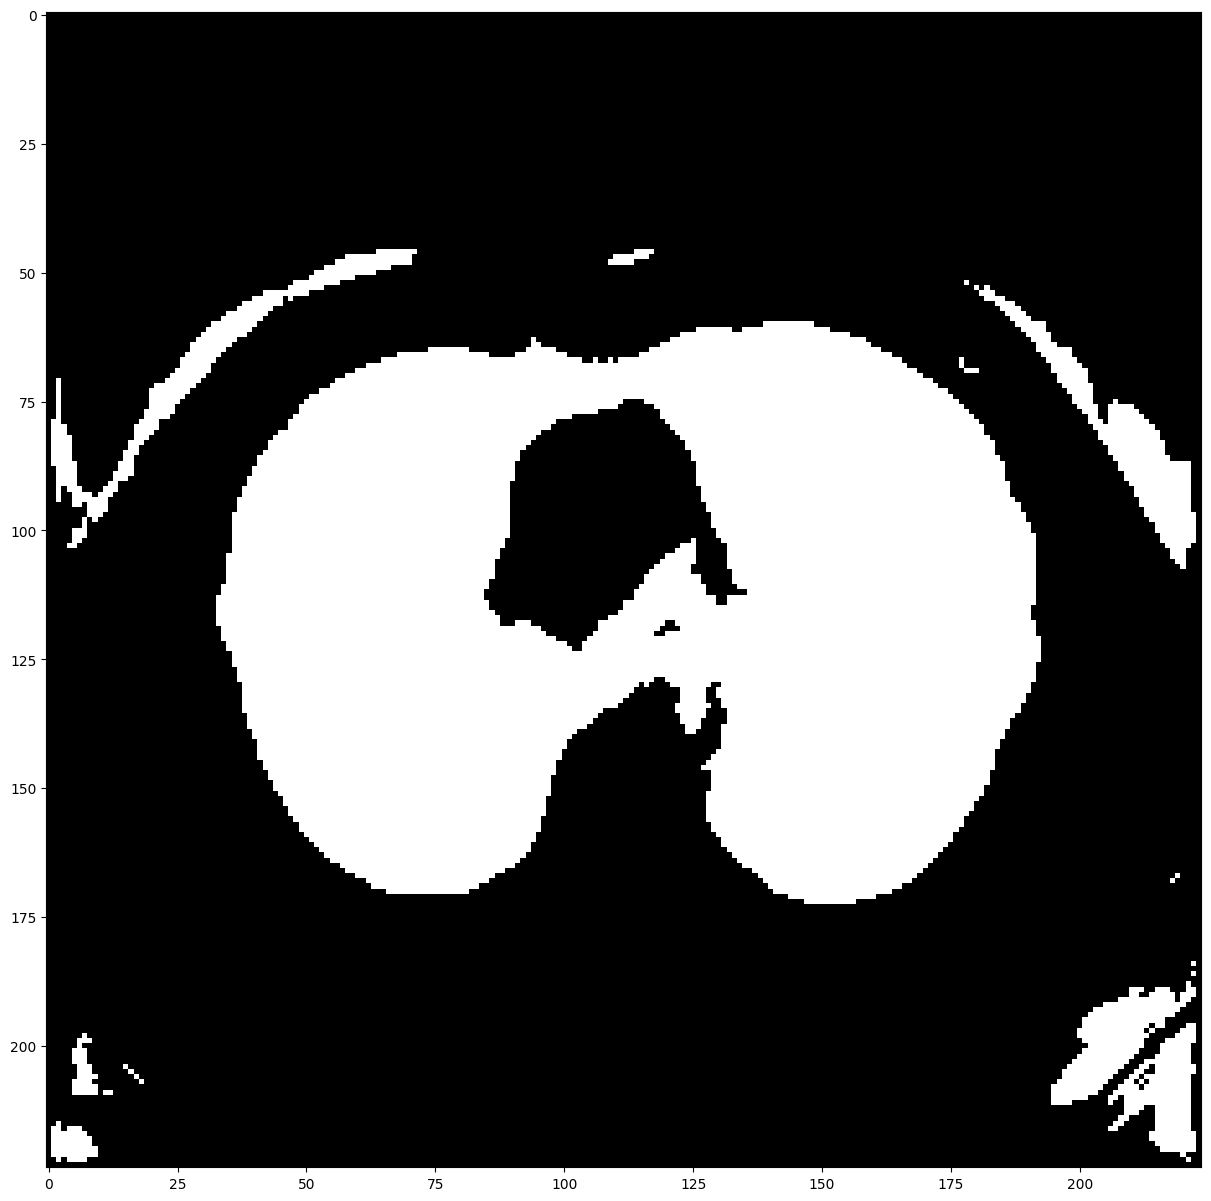

In [52]:
import torchvision
import matplotlib.pyplot as plt

def imshow_pred(img):
    npimg = img.numpy() * 255
    print(npimg.shape)
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
print(val_outputs[0].shape)
_, preds = torch.max(torch.tensor(val_outputs[0]), 1)
preds = torch.cat([preds.unsqueeze(1),preds.unsqueeze(1),preds.unsqueeze(1)],dim=1)
print(preds.shape)
imshow_pred(torchvision.utils.make_grid(preds.cpu(),nrow=4))

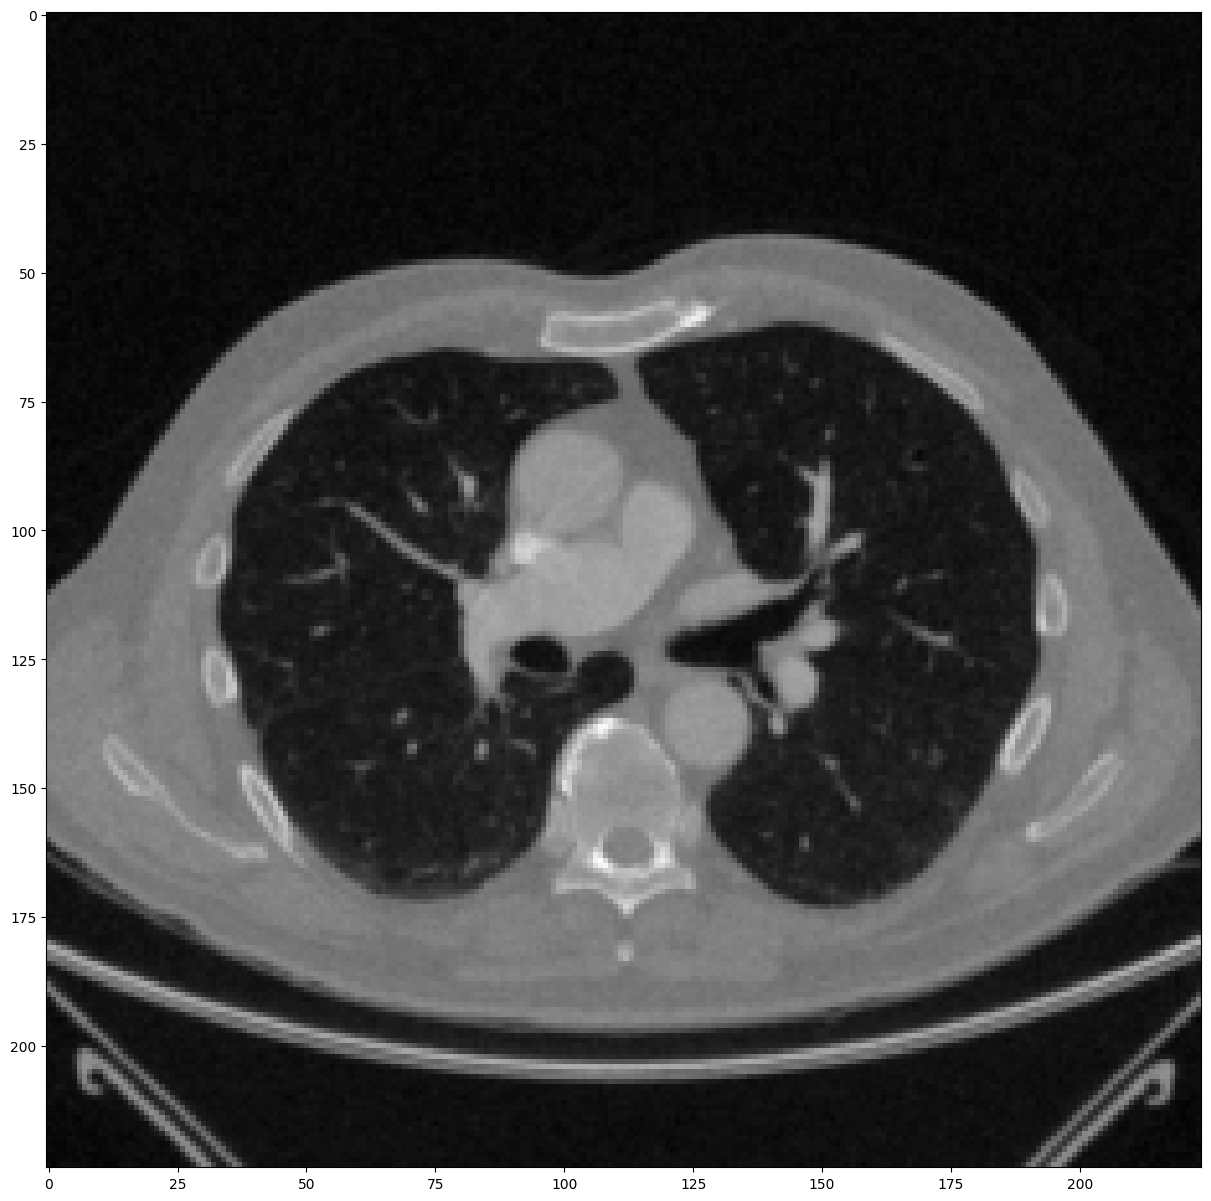

In [24]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
imshow(torchvision.utils.make_grid(img_value,nrow=4))

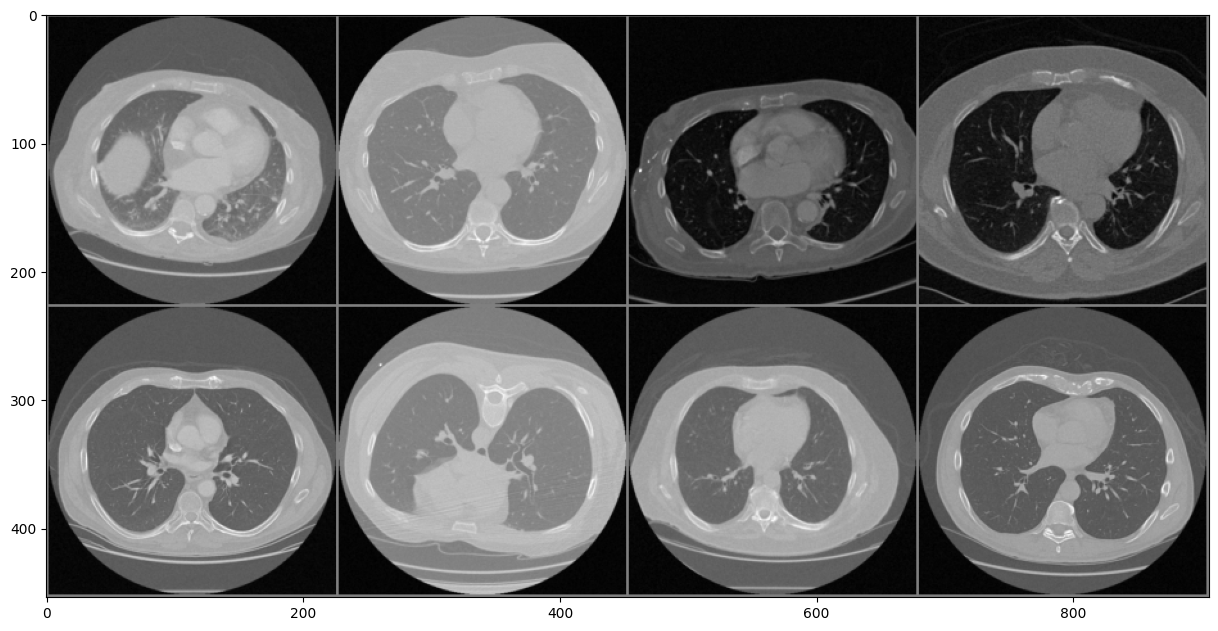

torch.Size([8, 3, 224, 224])
(3, 454, 906)


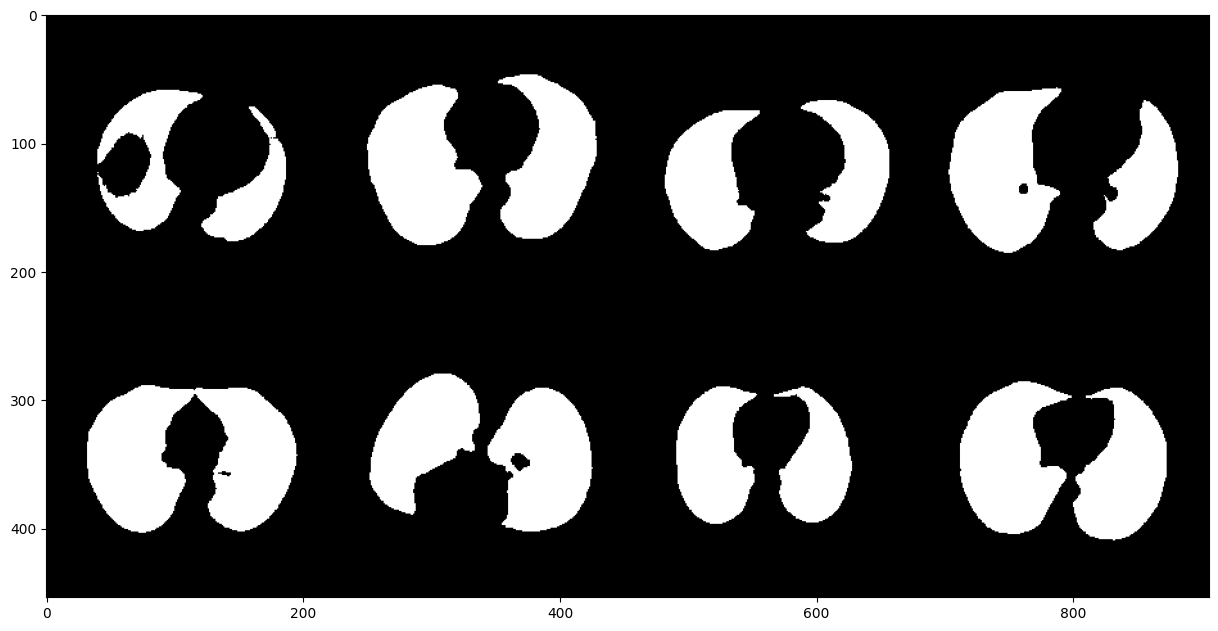

output, torch.Size([8, 2, 224, 224])
torch.Size([8, 3, 224, 224])
(3, 454, 906)


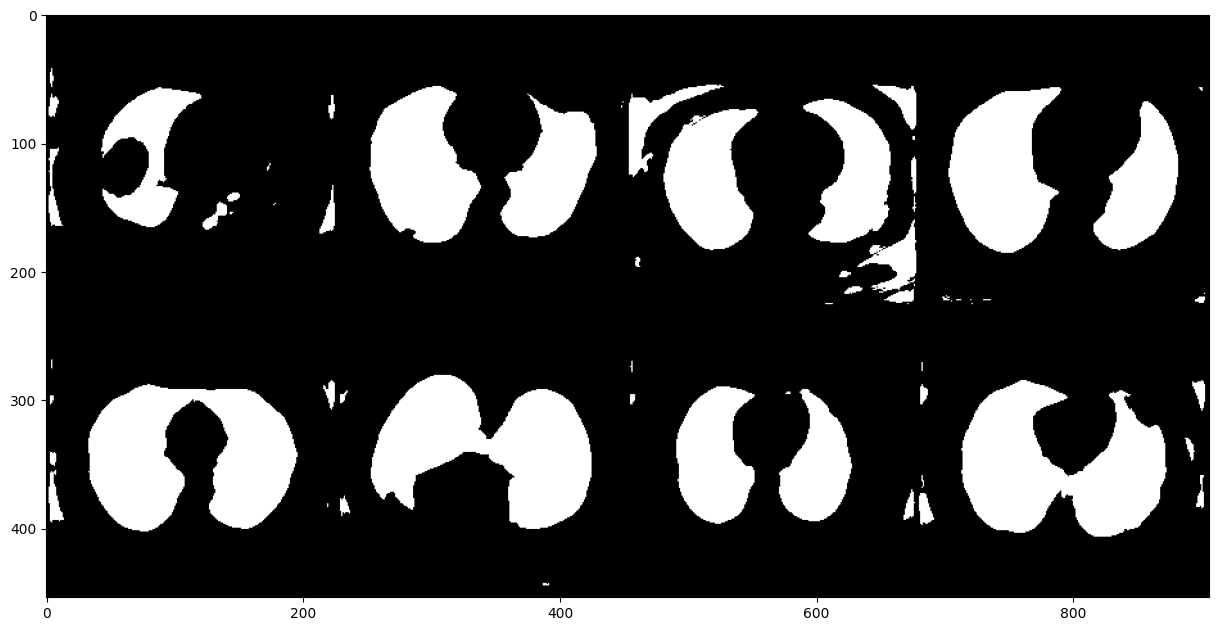

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
%matplotlib inline 
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imshow_pred(img):
    npimg = img.numpy() * 255
    print(npimg.shape)
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
for val_data in valid_loader:
    images, labels = val_data["img"], val_data["label"]
    break
#batch = dataiter.next()
#images, labels = batch['img'], batch['label']
# show images
imshow(torchvision.utils.make_grid(images,nrow=4))
labels_image = torch.cat([labels.unsqueeze(1),labels.unsqueeze(1),labels.unsqueeze(1)],dim=1)
print(labels_image.shape)
imshow_pred(torchvision.utils.make_grid(labels_image,nrow=4))
# print labels
output = model(images.to(device))
print("output,",output.shape)
_, preds = torch.max(output, 1)
preds = torch.cat([preds.unsqueeze(1),preds.unsqueeze(1),preds.unsqueeze(1)],dim=1)
print(preds.shape)
imshow_pred(torchvision.utils.make_grid(preds.cpu(),nrow=4))

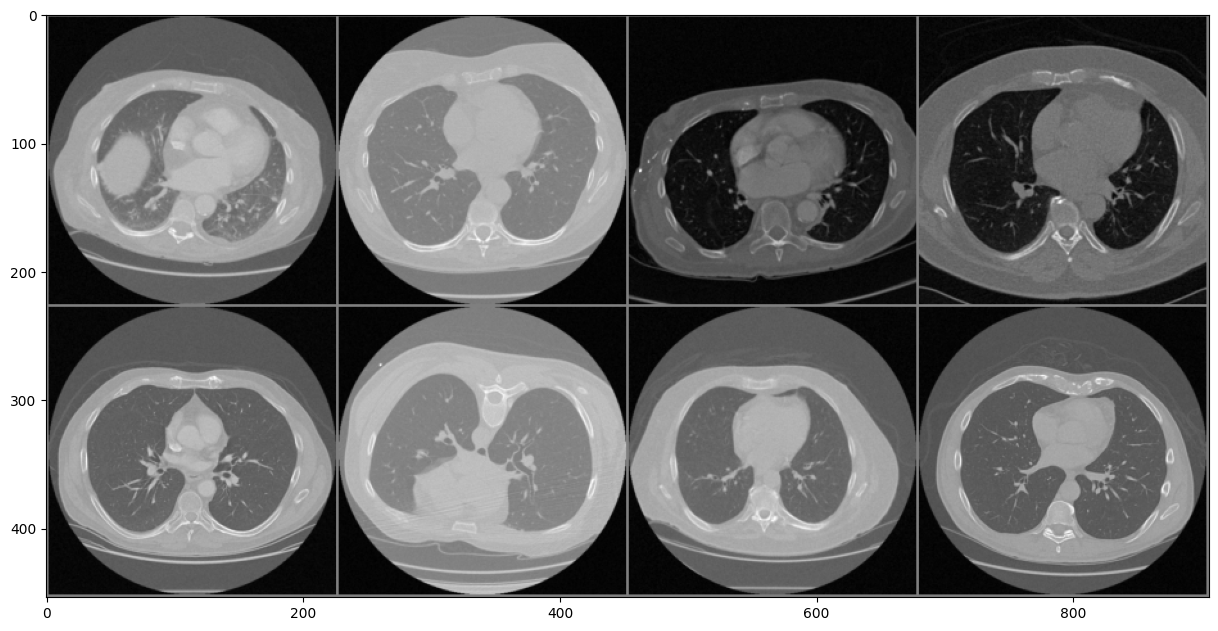

torch.Size([8, 3, 224, 224])
(3, 454, 906)


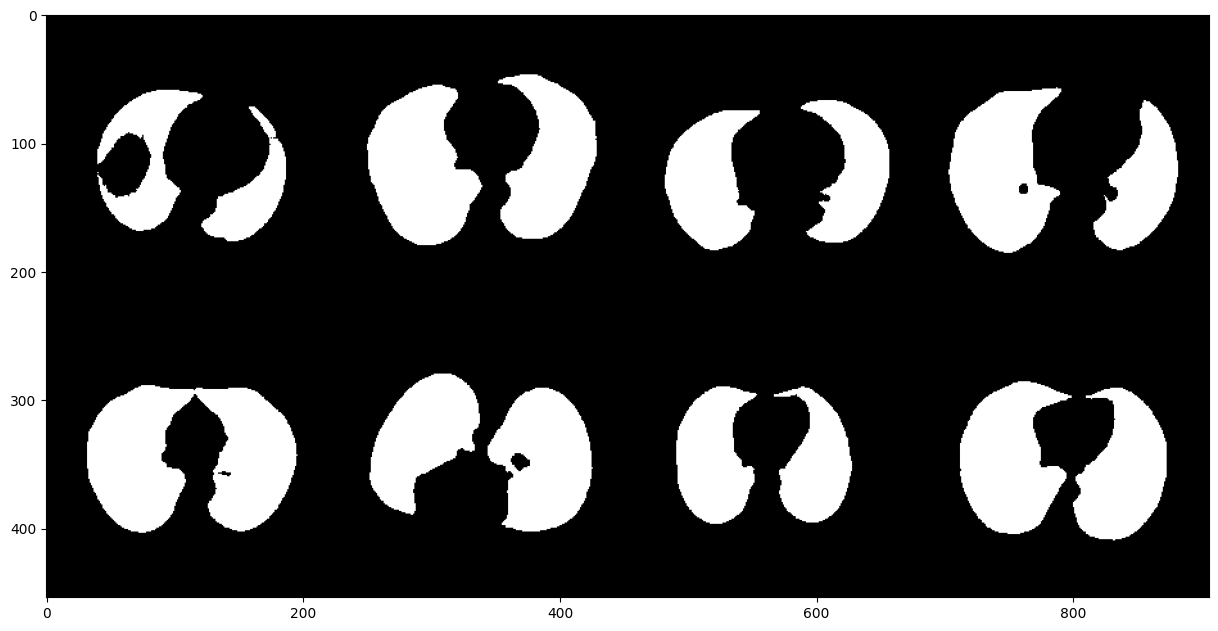

torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
(3, 454, 906)


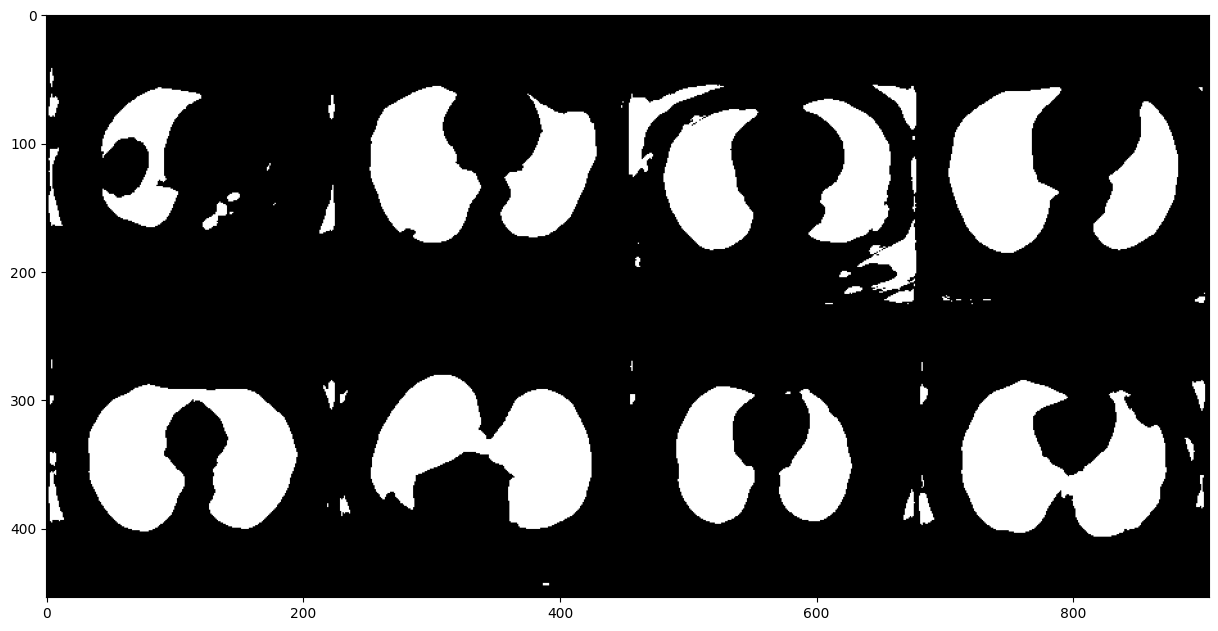

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import onnxruntime as ort
import psutil
%matplotlib inline 

# functions to show an image

def onnxpred(img):

    sess_options = ort.SessionOptions()
    sess_options.execution_mode = ort.ExecutionMode.ORT_PARALLEL
    sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
    sess_options.intra_op_num_threads = psutil.cpu_count(logical=True)
    modelonnx = ort.InferenceSession("segv1.onnx", sess_options,
                                     ["CPUExecutionProvider", "CUDAExecutionProvider"])

    val_outputs = modelonnx.run(None, {"input": [img.detach().numpy()]})
    return val_outputs

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imshow_pred(img):
    npimg = img.numpy() * 255
    print(npimg.shape)
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
#for val_data in valid_loader:
#    images, labels = val_data["img"], val_data["label"]
#    break
#batch = dataiter.next()
#images, labels = batch['img'], batch['label']
# show images
imshow(torchvision.utils.make_grid(images,nrow=4))
labels_image = torch.cat([labels.unsqueeze(1),labels.unsqueeze(1),labels.unsqueeze(1)],dim=1)
print(labels_image.shape)
imshow_pred(torchvision.utils.make_grid(labels_image,nrow=4))
# print labels
#output = model(images.to(device))
print(images.shape)
pred = []
for i in range(len(images)):
    imgsample = images[i]
    pred.append(onnxpred(imgsample)[0][0])
    
output = torch.tensor(pred)
_, preds = torch.max(output, 1)
preds = torch.cat([preds.unsqueeze(1),preds.unsqueeze(1),preds.unsqueeze(1)],dim=1)
print(preds.shape)
imshow_pred(torchvision.utils.make_grid(preds.cpu(),nrow=4))

In [58]:
len(pred),pred[0].shape,torch.tensor(pred).shape

(8, (2, 224, 224), torch.Size([8, 2, 224, 224]))